In [84]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot module

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

""" # Define the neural network architecture
class MultiplierModel(nn.Module):
    def __init__(self):
        super(MultiplierModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x) """

class MultiplierModel(nn.Module):
    def __init__(self):
        super(MultiplierModel, self).__init__()
        self.fc1 = nn.Linear(2, 128)  # First hidden layer with 128 units
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 units
        self.fc3 = nn.Linear(64, 32) 
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8) 
        self.fc6 = nn.Linear(8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x


# Generate random sample data
np.random.seed(42)
num_samples = 100000
X = np.random.rand(num_samples, 2).astype(np.float32)
y = (X[:, 0] * X[:, 1]).reshape(-1, 1).astype(np.float32)
#X = torch.rand((num_samples, 2))
#y = torch.prod(X, dim=1)


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, device=device)
y_train_tensor = torch.tensor(y_train, device=device)
X_val_tensor = torch.tensor(X_val, device=device)
y_val_tensor = torch.tensor(y_val, device=device)

# Create an instance of the model and move it to GPU if available
model = MultiplierModel().to(device)

# Attempt to load the model parameters from a file
try:
    model.load_state_dict(torch.load("model_multiplier2.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Model file not found. Creating a new model.")

#criterion = nn.L1Loss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.MSELoss()  # Use Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Calculate validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

print("Training finished!")

# Save the trained model
torch.save(model.state_dict(), 'model_multiplier2.pth')



Using device: cuda
Model loaded successfully.
Epoch [1/1000], Train Loss: 0.0000, Val Loss: 0.0020
Epoch [2/1000], Train Loss: 0.0020, Val Loss: 0.0001
Epoch [3/1000], Train Loss: 0.0001, Val Loss: 0.0006
Epoch [4/1000], Train Loss: 0.0005, Val Loss: 0.0012
Epoch [5/1000], Train Loss: 0.0012, Val Loss: 0.0007
Epoch [6/1000], Train Loss: 0.0006, Val Loss: 0.0001
Epoch [7/1000], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/1000], Train Loss: 0.0001, Val Loss: 0.0004
Epoch [9/1000], Train Loss: 0.0004, Val Loss: 0.0006
Epoch [10/1000], Train Loss: 0.0006, Val Loss: 0.0004
Epoch [11/1000], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [12/1000], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [13/1000], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [14/1000], Train Loss: 0.0001, Val Loss: 0.0003
Epoch [15/1000], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [16/1000], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [17/1000], Train Loss: 0.0002, Val Loss: 0.0000
Epoch [18/1000], Train Loss: 0.0000, Val Loss

0.5457 x 0.2670 = 0.1457 => Predicted Result: 0.1462
0.4277 x 0.5455 = 0.2333 => Predicted Result: 0.2333
0.0571 x 0.7893 = 0.0451 => Predicted Result: 0.0454
0.1794 x 0.4514 = 0.0810 => Predicted Result: 0.0809
0.8713 x 0.8222 = 0.7164 => Predicted Result: 0.7167


C:\Users\Admin\AppData\Local\Temp\ipykernel_17876\2251071828.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"{float(expected_result):.4f} => Predicted Result: {float(predicted_result):.4f}")


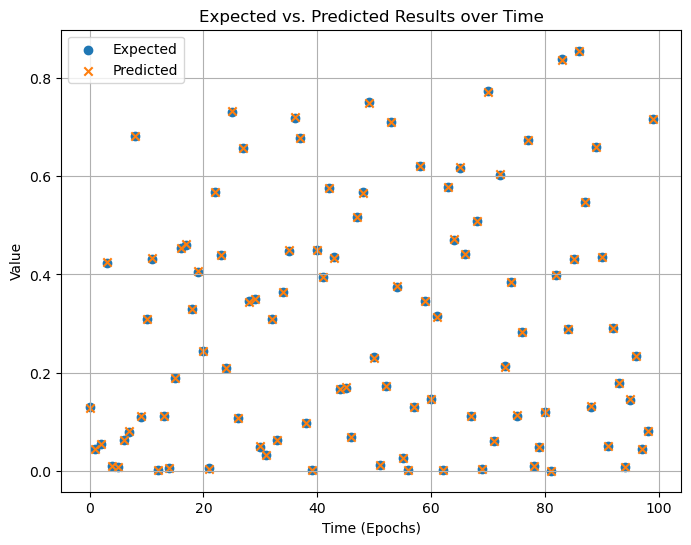

In [85]:


# Generate a new test dataset
X_test = np.random.rand(100, 2).astype(np.float32)
y_test = X_test.prod(axis=1)

# Convert the test data to PyTorch tensors and move to GPU if available
X_test_tensor = torch.tensor(X_test, device=device)

# Run predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_y = model(X_test_tensor)

# Move predictions and ground truth back to CPU for plotting
predicted_y = predicted_y.cpu().numpy()

# Print expected and predicted results along with their corresponding multipliers
for i in range(len(X_test) - 5, len(X_test)):
    multiplier1, multiplier2 = X_test[i]
    expected_result = y_test[i]
    predicted_result = predicted_y[i]
    print(f"{float(multiplier1):.4f} x {float(multiplier2):.4f} = "
          f"{float(expected_result):.4f} => Predicted Result: {float(predicted_result):.4f}")


# Create a plot with time (epochs) on the x-axis and both expected and predicted values as individual balls
plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, label='Expected', marker='o')
plt.scatter(range(len(X_test)), predicted_y, label='Predicted', marker='x')
plt.xlabel("Time (Epochs)")
plt.ylabel("Value")
plt.title("Expected vs. Predicted Results over Time")
plt.grid(True)
plt.legend()
plt.show()